# L5.9 Outliers

In [136]:
from ml import *
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

In [137]:
df = pd.read_csv('/data/datasets/cleanhouses.csv')

In [138]:
train_X, valid_X, train_y, valid_y = train_test_split(df[['GrLivArea']], df[['SalePrice']])

We scale the data and fit like normal on the training set and then observe the distance

In [139]:
# normalize the data and fit a model
scaler = StandardScaler()
train_X2 = scaler.fit_transform(train_X)
valid_X2 = scaler.transform(valid_X)
model = LinearRegression()
model.fit(train_X2, train_y)
sqrt(mean_squared_error(valid_y, model.predict(valid_X2)))

56944.10189075301

# Outliers

Outliers is also something that we should be aware of. Why? Because outliers in the training set can markedly affect our models. In the validation set, outliers will obscure our sense of if a model is trained well. However, they can also be a valuable source of information, providing us insights about specific behaviours.

Outliers is a complex subject and it deserves more attention. Here, we'll just do a quick analysis through the standard deviation of 'SalePrice' and a set of scatter plots.

One of the easiest ways to find outliers is to convert the scale of variables to a zero mean and 1 standard deviation. Although the distribution of a variable is not necessarily Normal, a large deviation from the mean is a simple indication of being an outlier. Remember that for Normally distributed variables, only 0.1% of the data will be more than 3\*SD away from the mean. 

### Z-score ouliers

We can apply a standard scaler to convert the scores to a z-distribution. We may observe values that are 6 or 7 standard deviations away from the mean. However, since there are quite a few values far away from the mean, we are likely to not have Normally distributed data, e.g. the data may be skewed, binomial, poisson, etc.

In [140]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(train_X);
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('\nouter range (high) of the distribution:')
print(high_range)


outer range (high) of the distribution:
[[3.21647677]
 [3.29341043]
 [3.51107642]
 [3.60865083]
 [3.69496665]
 [3.9107562 ]
 [3.94640839]
 [5.23926929]
 [5.53949824]
 [7.72741668]]


Therefore it may be better to first convert the data to a normal distribution and then inspect for outliers. We can do that using a box-cox transformation.

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


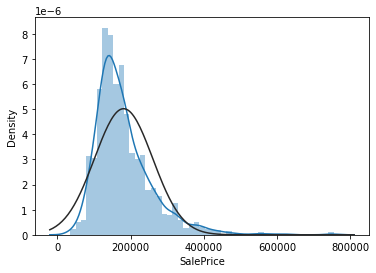

In [141]:
from scipy import stats
#histogram and normal probability plot
sns.distplot(df.SalePrice, fit=stats.norm);
#fig = plt.figure()

# alternatively you could plot a qq plot
#res = stats.probplot(df.SalePrice, plot=plt)

If SalePrice was normal distributed, the shape would more closely match the bell shape of the fitted normal distribution. The shape does not fit because on the one hand there is a skew (the peak is clearly left of the peak of the normal distribution) and slighty more difficult to see is the peakedness (kurtosis) since the ascent is more straight than curved. A somewhat easier way to check whether the data is normal distributed is to use a probability plot. If the data is normally distributed, the points would be closer to a straight line. 

The probablility plot also shows if the variance is constant throughout the range, and it is not. We can see the likelihood of the tails exceeds the fitted line. We can run a Box-Cox test to see if there is a transformation that is justified to normalize the data by a simple data transformation. The result of the test tells us what transformation function to use:

| Box-Cox | transformation of Y |
| -- | -- |
| -3 | $-Y^{-3}$ |
| -2 | $-Y^{-2}$ |
| -1 | $-1/Y$ |
| -0.5 | $-1/\sqrt Y$ |
| 0 | $log(Y)$ |
| 0.5 | $\sqrt Y$ |
| 1 | $Y$ |
| 2 | $Y^2$ |
| 3 | $Y^3$ |

In [142]:
boxcox = stats.boxcox(train_X.GrLivArea)[1]
boxcox

0.008580645569093777

The Box-Cox test gives us a small negative number, therefore either $-SalePrice^{boxcox}$ or using $log(SalePrice)$ should bring us closer to a normal distribution. Since the value is close to 0, a log transformation should work fine, but we will show both and compare.

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


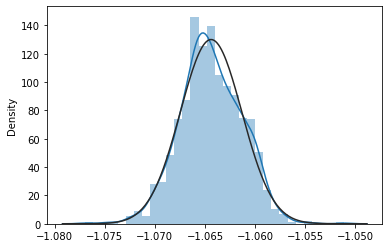

In [143]:
#histogram and normal probability plot
train_XT = -train_X ** boxcox
sns.distplot(train_XT, fit=norm);

### Remove extreme values

First we we inspect the z-scores below -3.5 and above 3.5. These are 3.5 standard deviation from the mean, meaning the chance of removing such a point given the normal distribution of the data is about 0.05%. Note that this threshold is arbitrary, but we often do not want to remove outliers too aggressively since we might lose predictive values around edges or when extrapolating.

In [144]:
train_XZ = StandardScaler().fit_transform(train_XT);
low_range = train_XZ[train_XZ < -3.5]
print('\nouter range (low) of the distribution:')
print(low_range)


outer range (low) of the distribution:
[-4.08628892]


In [145]:
high_range = train_XZ[train_XZ > 3.5]
print('\nouter range (high) of the distribution:')
print(high_range)


outer range (high) of the distribution:
[4.32295494]


remove them from both X and y in the training set.

In [146]:
#deleting points
train_XD = train_X[(train_XZ > -3.5) & (train_XZ < 3.5)]
train_yD = train_y[(train_XZ > -3.5) & (train_XZ < 3.5)]

Visually we can see the extreme outliers are gone.

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


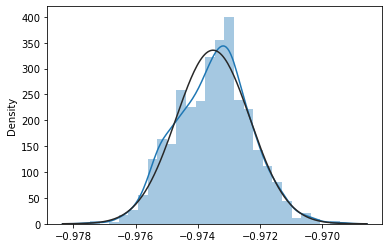

In [147]:
boxcox = stats.boxcox(train_XD.GrLivArea)[1]
sns.distplot(-train_XD ** boxcox, fit=stats.norm);

### Training on a set with less outliers

We then perform the same pipeline, scaling the data (note that does not really matter for linear regression) and fitting on the training set with outliers dropped.

Note that for a proper validation, we did NOT remove outliers from the validation set. And we should see that the fit on the validation set improves. In other words, we have learned a model that generalizes better or has a better predictive power on unseen data.

In [148]:
train_XD2 = scaler.fit_transform(train_XD)
valid_X2 = scaler.transform(valid_X)
model = LinearRegression()
model.fit(train_XD2, train_yD)
sqrt(mean_squared_error(valid_y, model.predict(valid_X2)))

57276.78276234779